In [39]:
using DataFrames
using Underscores
using Pkg
using Chain
using Optim


using Plots
gr()

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278


Plots.GRBackend()

In [40]:
# Scratch - delete
rosenbrock(x) = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2



rosenbrock (generic function with 1 method)

In [42]:
a = optimize(rosenbrock, [0.0, 0.0])

 * Status: success

 * Candidate solution
    Final objective value:     3.525527e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    60
    f(x) calls:    117


In [49]:
Optim.minimizer(a)

2-element Array{Float64,1}:
 0.9999634355313174
 0.9999315506115275

In [4]:
abstract type Team end
struct Aligned <: Team end
struct Unaligned <: Team end

In [5]:
aligned = Aligned()
unaligned = Unaligned()

Unaligned()

In [6]:
world1 = 1
world2 = 2

2

In [7]:
worlds = [world1, world2]

2-element Array{Int64,1}:
 1
 2

In [8]:
teams = [aligned, unaligned]

2-element Array{Team,1}:
 Aligned()
 Unaligned()

In [52]:
function make_rows(teams, worlds, aligned_measure, starting_resources)
    rows = []
    for i in eachindex(teams), j in eachindex(worlds)
        team = teams[i]
        world = worlds[j]
        if world == worlds[1]
            measure = aligned_measure
        else
            measure = 1.0
        end
        if i == j
            resource = starting_resources
        else
            resource = 0.0
        end
        
        row = (team = team, world = world, measure = measure, resource = resource)
        push!(rows, row)
    end
    return rows
end
                


make_rows (generic function with 1 method)

In [53]:
test_data = DataFrame(make_rows(teams, worlds, .1, 10.0^22))

,team,world,measure,resource
,Team,Int64,Float64,Float64
1,Aligned(),1,0.1,1.0e22
2,Aligned(),2,1.0,0.0
3,Unaligned(),1,0.1,0.0
4,Unaligned(),2,1.0,1.0e22


In [54]:
function get_utility(data; resource_col = "resource")
    return data.measure .* log10.(data[!, resource_col] .+ 1.0)
end

get_utility (generic function with 1 method)

In [56]:
test_data["utility"] = get_utility(test_data)

4-element Array{Float64,1}:
  2.2
  0.0
  0.0
 22.0

In [57]:
test_data

,team,world,measure,resource,utility
,Team,Int64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2
2,Aligned(),2,1.0,0.0,0.0
3,Unaligned(),1,0.1,0.0,0.0
4,Unaligned(),2,1.0,1.0e22,22.0


In [51]:
function equal_split_bargaining_strategy(data)
    # A simple bargaining strategy where we assume a successful negotiation
    # results in splitting resources evenly across each world. 
    resources_df = @chain data begin
    groupby(_, :world)
    combine(_, :resource => sum)
    end
    
    num_teams = length(unique(data.team))
    resources_df.resource_sum /= 2
    rename!(resources_df, ("resource_sum" => "bargain_resource")) 
    return innerjoin(data, resources_df, on=:world)
end
    
    
    
    
   

equal_split_bargaining_strategy (generic function with 1 method)

In [190]:
""" data is a DataFrame containing (at least) world and resource columns
team_proportions is a DataFrame containing team, world, and proportion columns
"""
function get_proportional_resource_split(data::DataFrame, team_proportions::DataFrame)
    resources_by_world = @chain data begin
    groupby(_, :world)
    combine(_, :resource => sum => :total_world_resource)
    end
    
    joint_data = innerjoin(team_proportions, resources_by_world, on=:world, makeunique=true)
    joint_data[!, "resource_after_split"] = joint_data.total_world_resource .* joint_data.proportion
    
    return joint_data
end

function get_proportional_resource_split(data::DataFrame, team_proportions::Array)
    team_proportions_df = copy(data)
    team_proportions_df[!, "proportion"] = team_proportions
    return get_proportional_resource_split(data, team_proportions_df)
end

get_proportional_resource_split (generic function with 2 methods)

In [191]:
test_team_proportions = test_data[:, ["team", "world"]]
test_team_proportions[!, "proportion"] .= .5

4-element Array{Float64,1}:
 0.5
 0.5
 0.5
 0.5

In [192]:
get_proportional_resource_split(test_data, test_team_proportions)

,team,world,proportion,total_world_resource,resource_after_split
,Team,Int64,Float64,Float64,Float64
1,Aligned(),1,0.5,1.0e22,5.0e21
2,Aligned(),2,0.5,1.0e22,5.0e21
3,Unaligned(),1,0.5,1.0e22,5.0e21
4,Unaligned(),2,0.5,1.0e22,5.0e21


In [193]:
test_data

,team,world,measure,resource,utility,gains
,Team,Int64,Float64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2,0.0
2,Aligned(),2,1.0,0.0,0.0,-22.0
3,Unaligned(),1,0.1,0.0,0.0,-2.2
4,Unaligned(),2,1.0,1.0e22,22.0,0.0


In [220]:
""" Calculate the Nash Bargaining Solution
per https://en.wikipedia.org/wiki/Cooperative_bargaining#The_Nash_bargaining_solution
The NBS is the source distribution that maximizes the product of each teams gains
relative to the utility they gain on disagreement
(u(x) - u(d))(v(x) - v(d))
"""
function NBS(data, utility_fn, disagreement_strategy)
    
    """ Set up the function to be maximized
        as input, take team aligned's share of resources for each
        world. """

    
    """ Optimization libraries assume we're trying to minimize a functionrather than
    maximize, so we just multiply by -1"""
    function loss(aligned_resources) 
        return -1 * get_gains(aligned_resources, data, utility_fn, disagreement_strategy)
    end
    
    inner_optimizer = NelderMead()
    results = optimize(loss, [0.0, 0.0], [1.0, 1.0], [0.5, 0.5], Fminbox(inner_optimizer))
    return results
end
    
 function get_gains(aligned_resources::Array, data, utility_fn, disagreement_strategy)
    gains_by_team = get_gains_df(aligned_resources, data, utility_fn, disagreement_strategy)

    objective = prod(gains_by_team.gains)
    return objective
end       
    
function get_gains_df(aligned_resources::Array, data, utility_fn, disagreement_strategy)
    unaligned_resources = 1.0 .- aligned_resources
    all_resources = vcat(aligned_resources, unaligned_resources)
    split_resources = get_proportional_resource_split(data, all_resources)
    proposed_utilities = utility_fn(split_resources, resource_col="resource_after_split")
    disagreement_utilities = disagreement_strategy(split_resources, resource_col="resource") 

    data[!, "gains"] .= proposed_utilities .- disagreement_utilities
    gains_by_team = @chain data begin 
        groupby(_, :team)
        combine(_, :gains => sum => :gains)
    end
    return gains_by_team
end   

get_gains_df (generic function with 1 method)

In [221]:
# Check world 2 utility
@chain test_data begin
    filter(:world => ==(world2), _)
    combine(_, :resource => sum => :resource, :measure => maximum => :measure)
    get_utility
end
    

1-element Array{Float64,1}:
 22.0

In [222]:
# Assigning all the resources in world 2 to team aligned should increase its
# utility by the above amount (since it starts at 0), and decrease
# team unaligned's utility by the same amount
get_gains_df([1.0, 1.00], test_data, get_utility, get_utility)

,team,gains
,Team,Float64
1,Aligned(),22.0
2,Unaligned(),-22.0


In [233]:
test_NBS = NBS(test_data, get_utility, get_utility)

 * Status: success

 * Candidate solution
    Final objective value:     -4.493076e+01

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.35e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    165
    ∇f(x) calls:   1


In [235]:
test_NBS.minimizer

2-element Array{Float64,1}:
 0.09351900737980039
 0.09352568445050669

In [267]:
get_proportional_resource_split(test_data, vcat(test_NBS.minimizer, 1 .- test_NBS.minimizer)) 

,team,world,measure,resource,utility,gains,proportion,total_world_resource
,Team,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,Aligned(),1,0.1,1.0e22,2.2,-0.10291,0.093519,1.0e22
2,Aligned(),2,1.0,0.0,0.0,20.9709,0.0935257,1.0e22
3,Unaligned(),1,0.1,0.0,0.0,2.19574,0.906481,1.0e22
4,Unaligned(),2,1.0,1.0e22,22.0,-0.0426445,0.906474,1.0e22


In [237]:
function standard_failure(data)
    return get_utility(data, resource_col="resource")
end

standard_failure (generic function with 1 method)

In [242]:
function expected_utilities(data, utility_fn, bargaining_strategy, bargain_failure_utility, p_bargaining_success)
    # Get expected utility grouped by team, based on the utility, bargaining strategy, and probability
    # that bargaining succeeds
    aligned_resource_bargained = bargaining_strategy(data, utility_fn, bargain_failure_utility).minimizer
    data_with_bargain_resources::DataFrame = get_proportional_resource_split(data, vcat(aligned_resource_bargained, 1 .- aligned_resource_bargained))
    bargain_success_utility = utility_fn(data_with_bargain_resources, resource_col="resource_after_split")
    bargain_fail_utility = bargain_failure_utility(data_with_bargain_resources)
    data_with_bargain_resources[!, "expected_utility"] = p_bargaining_success .* bargain_success_utility + (1 - p_bargaining_success) .* bargain_fail_utility
    return data_with_bargain_resources
end
    
    

expected_utilities (generic function with 1 method)

In [243]:
function aligned_utility(teams, worlds, get_utility, bargaining_strategy, bargain_failure_utility, p_bargaining_success, aligned_measure, initial_resource)
    df = make_rows(teams, worlds, aligned_measure, initial_resource) |> DataFrame
    eu = expected_utilities(df, get_utility, bargaining_strategy, bargain_failure_utility, p_bargaining_success)
    return @_ eu |> filter(_.team == aligned, __) |> sum(__.expected_utility)
end

aligned_utility (generic function with 1 method)

In [244]:
aligned_utility(teams, worlds, get_utility, NBS, get_utility, .1, .1, 10e22)

4.486742806735734

In [257]:
measures = [10.0^n for n in LinRange(-10, 10, 25)]

24-element Array{Float64,1}:
      1.0e-10
      7.405684692262443e-10
      5.484416576121026e-9
      4.061585988376988e-8
      3.007882518043102e-7
      2.2275429519995564e-6
      1.649648074098024e-5
      0.00012216773489967932
      0.0009047357242349284
      0.006700187503509584
      0.04961947603002898
      0.3674661940736688
      2.7213387683753085
     20.153376859417268
    149.24955450518323
   1105.2951411260233
   8185.4673070690205
  60618.98993497548
 448925.12582186074
      3.324597932270938e6
      2.4620924014946204e7
      1.8233480008684385e8
      1.350314037869872e9
      1.0e10

In [256]:
probabilities = LinRange(1e-3, 1 - 1e-3, 5)

5-element LinRange{Float64}:
 0.001,0.2505,0.5,0.7495,0.999

In [251]:
function utility_from_measure_and_probability((probability, measure))
    return aligned_utility(teams, worlds, get_utility, NBS, get_utility, probability, measure, 1e22)
end

utility_from_measure_and_probability (generic function with 1 method)

In [252]:
function aligned_gain_ratio((probability, measure); step_size = 1.01)
    default = utility_from_measure_and_probability((probability, measure))
    gain_from_increased_measure = utility_from_measure_and_probability((probability, measure * step_size))
    gain_from_increased_bargaining = utility_from_measure_and_probability((probability * step_size, measure))
    
    return ((gain_from_increased_measure - gain_from_increased_bargaining) / default)
end
    

aligned_gain_ratio (generic function with 1 method)

In [258]:
probabilities_and_measures = Base.product(probabilities, measures) |> collect

5×24 Array{Tuple{Float64,Float64},2}:
 (0.001, 1.0e-10)   (0.001, 7.40568e-10)   …  (0.001, 1.0e10)
 (0.2505, 1.0e-10)  (0.2505, 7.40568e-10)     (0.2505, 1.0e10)
 (0.5, 1.0e-10)     (0.5, 7.40568e-10)        (0.5, 1.0e10)
 (0.7495, 1.0e-10)  (0.7495, 7.40568e-10)     (0.7495, 1.0e10)
 (0.999, 1.0e-10)   (0.999, 7.40568e-10)      (0.999, 1.0e10)

In [259]:
utilities_grid = map(utility_from_measure_and_probability, probabilities_and_measures)

5×24 Array{Float64,2}:
  0.0125668   0.013566   0.013905  …  4.01137e9  2.97069e10  2.2e11
  3.14797     3.39827    3.48318      4.01137e9  2.97069e10  2.2e11
  6.28338     6.78297    6.95246      4.01137e9  2.97069e10  2.2e11
  9.41879    10.1677    10.4217       4.01137e9  2.97069e10  2.2e11
 12.5542     13.5524    13.891        4.01137e9  2.97069e10  2.2e11

In [260]:
gains_grid = map(aligned_gain_ratio, probabilities_and_measures)

5×24 Array{Float64,2}:
 -0.01  -0.00999998  -0.00999983  …  0.01        0.01  0.01  0.01  0.01
 -0.01  -0.01        -0.01           0.01        0.01  0.01  0.01  0.01
 -0.01  -0.01        -0.01           0.01        0.01  0.01  0.01  0.01
 -0.01  -0.01        -0.01           0.01        0.01  0.01  0.01  0.01
 -0.01  -0.01        -0.01           0.00999999  0.01  0.01  0.01  0.01

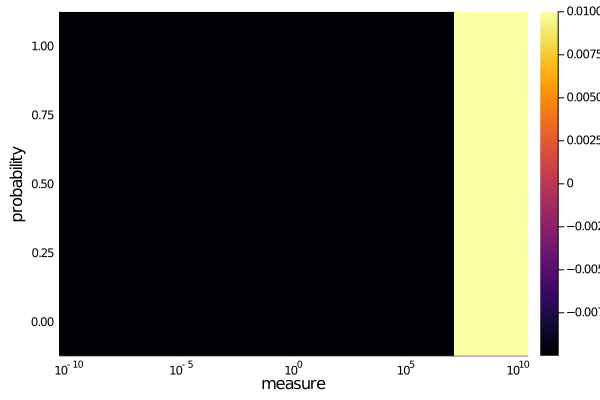

In [265]:
heatmap1 = heatmap(measures, probabilities, gains_grid, xaxis = :log, xlabel = "measure", ylabel = "probability")

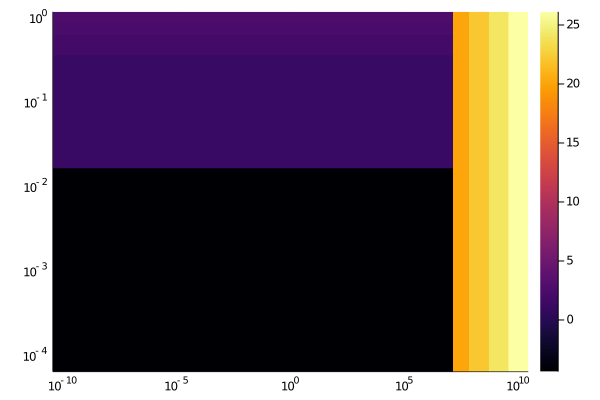

In [266]:
heatmap2 = heatmap(measures, probabilities, log.(utilities_grid), yaxis = :log10, xaxis = :log10, zscale = :log10)